In [1]:
import numpy as np
from fractions import Fraction
import qiskit.visualization
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator

### cAddModN

In [2]:
def sim(circuit, simulator, shots,x_val,y_val,N,n_qubits):
    display(qiskit.visualization.plot_distribution(simGetCounts(circuit, simulator, shots,), title=rf" {x_val}+{y_val} mod {N} = ${(x_val+y_val)%N }_{{10}}$ = ${((x_val+y_val)%N):0{n_qubits}b}_{{2}}$ "))
def simMul(circuit, simulator, shots,x_val,y_val,N,n_qubits):
    display(qiskit.visualization.plot_distribution(simGetCounts(circuit, simulator, shots,), title=rf" {x_val}*{y_val} mod {N} = ${(x_val*y_val)%N }_{{10}}$ = ${((x_val*y_val)%N):0{n_qubits}b}_{{2}}$ "))


def simGetCounts(circuit, simulator, shots):
    return simulator.run(qiskit.transpile(circuit, simulator),shots=shots).result().get_counts(0)

In [3]:
def qft_adder(qc,qr,y_val,isless=False):
    # Apply QFT 
    qft = QFT(len(qr), do_swaps=False)
    qc.append(qft,qr )
    
    # Apply controlled phase rotations
    for i in range(len(qr)):
            theta = 2 * np.pi*y_val / (2 ** (i + 1))
            qc.p(theta, qr[i])
    # Apply inverse QFT 
    iqft = QFT(len(qr), do_swaps=False).inverse()
    qc.append(iqft, qr)
    if isless:
        qc.barrier()
    return qc

In [4]:
def isless(qc,qr, a,c,y_val):
    qft_adder(qc,[*qr,*a],-y_val)
    qc.cx(a,c)
    qft_adder(qc,[*qr,*a],y_val)
    return qc

In [5]:
def Cqft_adder(qc,qr,c,y_val):
    """
        assuming the first Quantum register is the x+1-register, and the second  is c1
    """
    # Apply QFT 
    qft = QFT(len(qr), do_swaps=False)
    qc.append(qft,qr )
    
    # Apply controlled phase rotations
    for i in range(len(qr)):
            theta = 2 * np.pi*y_val / (2 ** (i + 1))
            qc.cp(theta,c,qr[i])
    # Apply inverse QFT 
    iqft = QFT(len(qr), do_swaps=False).inverse()
    qc.append(iqft, qr)
    
    return qc.to_instruction()

In [6]:
def Cisless(qc,qr, a,c,control,y_val):
    Cqft_adder(qc,[*qr,*a],control,-y_val)
    qc.cx(a,c)
    Cqft_adder(qc,[*qr,*a],control,y_val)
    return qc

In [7]:
def addmodN(qc,qr,a,c,y_val,N):
    isless(qc,qr,a,c,N-y_val)
    qft_adder(qc,qr,y_val)
    Cqft_adder(qc,qr,c,-N,)
    # qft_adder(qc,[*qr,*a],-y_val)
    # qc.x(a)
    # qc.cx(a,c)
    # qc.x(a)
    # qft_adder(qc,[*qr,*a],y_val)
    return qc

In [8]:
def CaddmodN(qc,qr,a,c,control,y_val,N):
    y_val = y_val%N
    c1,c2 = c[0],c[1]
    Cisless(qc,qr,a,c1,control,N) #x<N
    Cisless(qc,qr,a,c2,control,N-y_val)
    qc.barrier() # for adding mod N
    #case c1=true and c2=False
    qc.x(c2)
    qc.ccx(c1,c2,a)
    qc.x(c2)
    qc.barrier()
    Cqft_adder(qc,qr,a,y_val-N)
    qc.x(c2)
    qc.ccx(c1,c2,a)
    qc.x(c2)
    qc.barrier()
    # case c1=True and C2=True
    qc.ccx(c1,c2,a)
    Cqft_adder(qc,qr,a,y_val)
    qc.ccx(c1,c2,a)
    qc.barrier()
    Cisless(qc,qr,a,c2,control, y_val)
    qc.cx(c1,c2)
    Cisless(qc,qr,a,c1,control,N)
    return qc

In [9]:
x_val =9
y_val = 1
N_val=11
# ensures that x register is large enough to fit arbitrary mod N operation
n_qubits = max(int(np.ceil(np.log2(x_val)+1)),int(np.ceil(np.log2(N_val)+1)) ) 

In [10]:
qr = QuantumRegister(n_qubits,'x')
a = QuantumRegister(1,'a')
c = QuantumRegister(2,'c')
control = QuantumRegister(1,'control')
# cl = ClassicalRegister(n_qubits)
circ = QuantumCircuit(qr,a,c,control)
for i in range(n_qubits):
        if (x_val & (1 << i)):
            circ.x(qr[i])
circ.x(control)
circ.barrier()
CaddmodN(circ,qr,a,c,control,y_val,N_val)

In [11]:

# circ.measure(circ.qregs[0][:],circ.cregs[0][:n_qubits])
circ.measure_all()

In [12]:
# circ.draw('mpl')

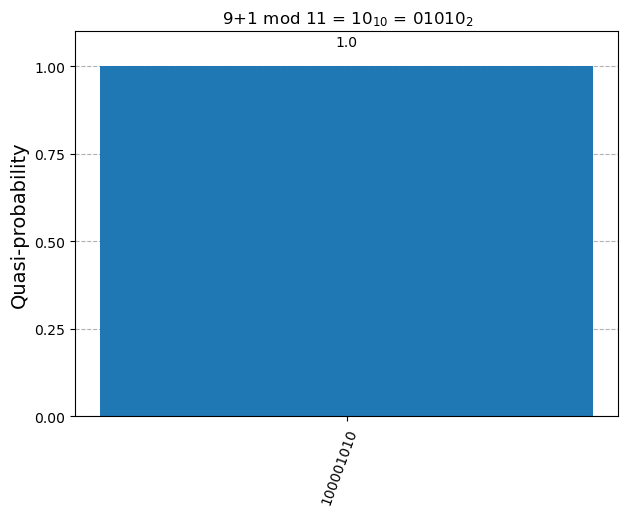

In [13]:
sim(circ,AerSimulator(),1000,x_val,y_val,N_val,5)

### cMulModN

In [14]:
def summands(y,N,n_qubits):
    r = np.zeros(n_qubits)
    for i in range(0,n_qubits):
        s = 0
        for j in range(0,n_qubits):
            s = s+int(np.binary_repr(y,n_qubits)[::-1][j])*2**(i+j)
        r[i] = s % N
    return r

In [15]:
def eEa(a,b):
    if (a==0): 
        return (b,0,1)
    gcd, x,y, = eEa(b%a,a)
    return (gcd,y-(b//a)*x,x)

def moduloinverse(a,n):
    gcd, x,_ = eEa(a,n)
    if gcd !=1:
        raise VauleError("Mod inverse does not exists")
    return x%n

In [40]:
def c_mult_mod_N(qc,qr,qr1,a,control,y_val,N):
    n = len(qr1)
    s = summands(y_val,N,n)

    for i in range(n):
        qc.ccx(control,qr[i],a[3])
        qc.barrier()
        CaddmodN(qc,qr1,[a[2]],a[0:2],a[3],s[i],N)
        qc.ccx(control,qr[i],a[3])
    for i in range(n):
        qc.cswap(control,qr[i],qr1[i])
    y_inv  = N-moduloinverse(y_val,N)
    s_inv = summands(y_inv,N,n)
    for i in range(n):
        qc.ccx(control,qr[i],a[3])
        CaddmodN(qc,qr1,[a[2]],a[0:2],a[3],s_inv[i],N)
        qc.ccx(control,qr[i],a[3])
    return qr

In [41]:
x_val =9
y_val = 2
N_val=11
# ensures that x register is large enough to fit arbitrary mod N operation
n_qubits = max(int(np.ceil(np.log2(x_val)+1)),int(np.ceil(np.log2(N_val)+1)) ) 

In [47]:
qr = QuantumRegister(n_qubits,'x')
qr1 = QuantumRegister(n_qubits,'z')
a0 = QuantumRegister(4,'a')
# c = QuantumRegister(2,'c')
control = QuantumRegister(1,'control')
# cl = ClassicalRegister(n_qubits)
circ1 = QuantumCircuit(qr,qr1,a,control)
for i in range(n_qubits):
        if (x_val & (1 << i)):
            circ1.x(qr[i])
circ1.x(control)
circ1.barrier()
c_mult_mod_N(circ1,qr,qr1,a,control,y_val,N_val)
# circ1.measure(qr,cl)
circ1.measure_all()

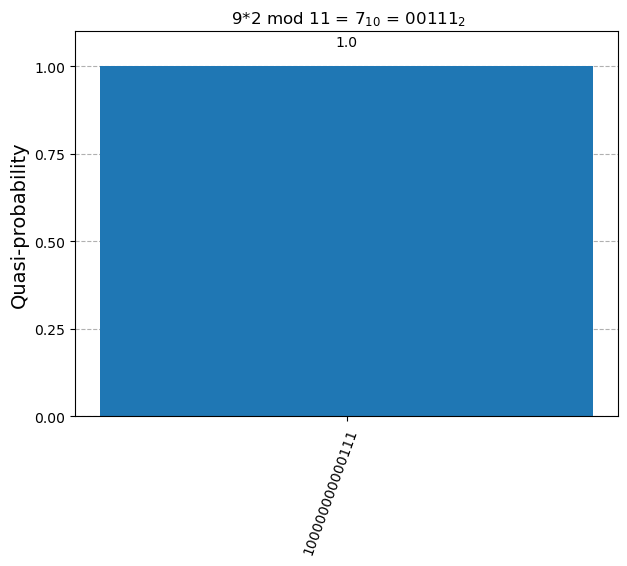

In [48]:
simMul(circ1,AerSimulator(),1000,x_val,y_val,N_val,n_qubits)